In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc

In [2]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")

# Create model with no observed data

In [33]:
data_len = 8550

In [34]:
with pm.Model() as model:

    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std,
        shape=(data_len)
    )
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential(
        "precip_posterior", 
        precip_prior, 
        shape=(data_len)
    )
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(data_len)) + (drought_coefs[3] * np.ones(data_len))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior)
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

# Fix some values for fun

In [3]:
set_values = {
    "temp_mixture_weights" : [1,1,1],
    "temp_prior" : [[0,0,0]],
    "temp_std" : [1,1,1],
    "precip_prior" : 1,
    "drought_coefs" : [0,0,0,0],
    "temp_tfp_coef" : 0,
    "temp_tfp_coef2" : 0,
    "precip_tfp_coef" : 0,
    "precip_tfp_coef2" : 0,
    "drought_tfp_coef" : -10,
    "tfp_intercept" : 0
}
model_simulate = do(model, set_values)

In [85]:
with model_simulate:
    simulate = pm.sample_prior_predictive(10000)
    observed = {
        "temp": simulate.prior["temp_posterior"].values.flatten(),
        "precip": simulate.prior["precip_posterior"].values.flatten(),
        "drought": simulate.prior["drought_posterior"].values.flatten(),
        "tfp": simulate.prior["tfp_posterior"].values.flatten()
    }
    df = pd.DataFrame(observed).sort_values("temp", ascending=False)

Sampling: [drought_posterior, precip_posterior, temp_posterior, tfp_posterior, tfp_std]


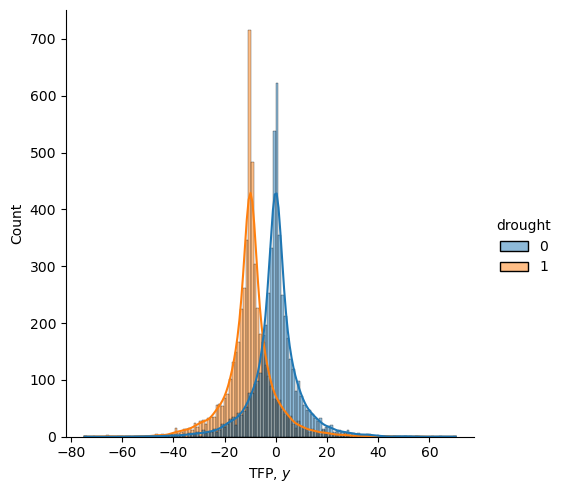

In [86]:
ax = sns.displot(data=df, x="tfp", hue="drought", kde=True)
ax.set(xlabel="TFP, $y$");

# Now fix drought and infer ag tfp at the global level

In [5]:
temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
normalized_temp = temp_scaler.fit_transform(np.array(integrated_data["Unweighted_Temp"]).reshape(-1,1)).flatten()
normalized_precip = precip_scaler.fit_transform(np.array(integrated_data["Precipitation"]).reshape(-1,1)).flatten()
normalized_tfp = tfp_scaler.fit_transform(np.array(integrated_data["TFP_Change"]).reshape(-1,1)).flatten()

In [30]:
observed_model = observe(model, {
    "temp_posterior":normalized_temp,
    "precip_posterior":normalized_precip,
})

drought_model = do(observed_model, {"drought_posterior": np.ones(len(normalized_temp), dtype="int32")})
no_drought_model = do(observed_model, {"drought_posterior": np.zeros(len(normalized_temp), dtype="int32")})

global_trace = pd.read_pickle(f"../models/temp_precip_drought_tfp_global.pkl")["trace"]

no_drought_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=no_drought_model,
    var_names=["tfp_posterior"]
)
drought_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=drought_model,
    var_names=["tfp_posterior"]
)

no_drought_samples_transform = tfp_scaler.inverse_transform(
    np.array(no_drought_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
drought_samples_transform = tfp_scaler.inverse_transform(
    np.array(drought_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()

Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


ATE: -0.7149161274814134
Probability that tfp will increase with low temp:  0.5344198486412108
Probability that tfp will increase with high temp:  0.4981517887856897


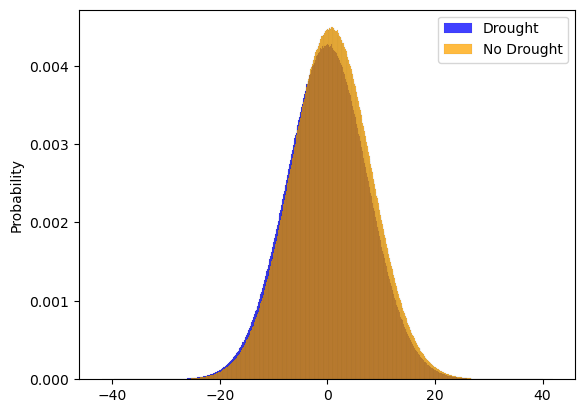

In [32]:
ATE_est = np.mean(drought_samples_transform-no_drought_samples_transform)
print("ATE:", ATE_est)

fig, ax = plt.subplots()
sns.histplot(data=np.array(drought_samples_transform), stat='probability', bins=1000, ax=ax, color="blue", label = "Drought")
sns.histplot(data=np.array(no_drought_samples_transform), stat='probability', bins=1000, ax=ax, color="orange", label = "No Drought")
ax.legend()
high_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
low_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with low temp: ", np.sum(low_height))
print("Probability that tfp will increase with high temp: ", np.sum(high_height))

# Fix temp and infer ag output

In [35]:
observed_model = observe(model, {
    # "drought_posterior":[val for index, val in enumerate(integrated_data["Drought"]) if not np.isnan(list(integrated_data["Unweighted_Temp"])[index])],
    "drought_posterior":[1 for i in range(data_len)],
    "precip_posterior":[val for index, val in enumerate(normalized_precip) if not np.isnan(list(integrated_data["Unweighted_Temp"])[index])]
})

global_trace = pd.read_pickle(f"../models/temp_precip_drought_tfp_global.pkl")["trace"]

mean_temp = temp_scaler.transform(np.array([val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_1_5 = temp_scaler.transform(np.array([1.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_0 = temp_scaler.transform(np.array([2.0 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_5 = temp_scaler.transform(np.array([2.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()

model_0 = do(observed_model, {"temp_posterior": mean_temp})
model_1_5 = do(observed_model, {"temp_posterior": mean_temp_1_5})
model_2_0 = do(observed_model, {"temp_posterior": mean_temp_2_0})
model_2_5 = do(observed_model, {"temp_posterior": mean_temp_2_5})

model_0_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_0,
    var_names=["tfp_posterior"]
)
model_1_5_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_1_5,
    var_names=["tfp_posterior"]
)
model_2_0_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_0,
    var_names=["tfp_posterior"]
)
model_2_5_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_5,
    var_names=["tfp_posterior"]
)

Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


In [36]:
model_0_transform = tfp_scaler.inverse_transform(
    np.array(model_0_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_1_5_transform = tfp_scaler.inverse_transform(
    np.array(model_1_5_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_2_0_transform = tfp_scaler.inverse_transform(
    np.array(model_2_0_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_2_5_transform = tfp_scaler.inverse_transform(
    np.array(model_2_5_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()

ATE_est_1_5 = np.mean(model_0_transform - model_1_5_transform)
ATE_est_2_0 = np.mean(model_0_transform - model_2_0_transform)
ATE_est_2_5 = np.mean(model_0_transform - model_2_5_transform)

print("ATE 1.5:", ATE_est_1_5)
print("ATE 2.0:", ATE_est_2_0)
print("ATE 2.5:", ATE_est_2_5)

ATE 1.5: 0.048331180005578636
ATE 2.0: 0.06638430241707677
ATE 2.5: 0.08462032815226349


# Compute change in global TFP based on temp scenarios

In [77]:
print((global_tfp[-1] - scenario_1_5[-1]) / global_tfp[-1])

0.023380821549133634


/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_4030/2661810296.py:5: RuntimeWarning: Mean of empty slice
  if not np.isnan(np.nanmean(global_tfp_mean)):


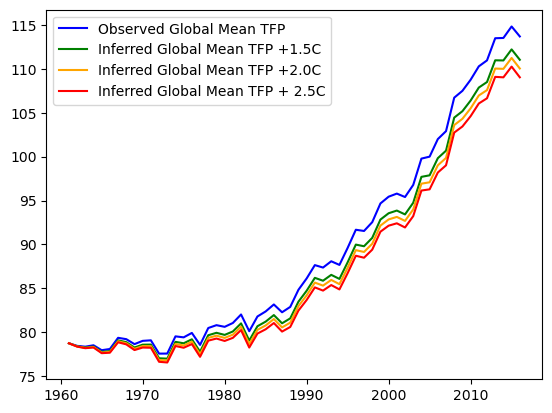

In [69]:
global_tfp = []
years = []
for year in set(integrated_data["Year"]):
    global_tfp_mean = integrated_data.loc[(integrated_data["Year"] == year) & (integrated_data["TFP"])]["TFP"]
    if not np.isnan(np.nanmean(global_tfp_mean)):
        global_tfp.append(np.nanmean(global_tfp_mean))
        years.append(year)
    
plt.plot(years, global_tfp, color="blue", label="Observed Global Mean TFP ")
scenario_1_5 = []
for index, value in enumerate(global_tfp):
    scenario_1_5.append(value - (index * ATE_est_1_5))
scenario_2_0 = []
for index, value in enumerate(global_tfp):
    scenario_2_0.append(value - (index * ATE_est_2_0))
scenario_2_5 = []
for index, value in enumerate(global_tfp):
    scenario_2_5.append(value - (index * ATE_est_2_5))
plt.plot(years, scenario_1_5, color="green", label="Inferred Global Mean TFP +1.5C")
plt.plot(years, scenario_2_0, color="orange", label="Inferred Global Mean TFP +2.0C")
plt.plot(years, scenario_2_5, color="red", label="Inferred Global Mean TFP + 2.5C")
plt.legend()

Probability that tfp will increase with low temp:  1.0596313157894737
Probability that tfp will increase with high temp:  1.0649202339181287


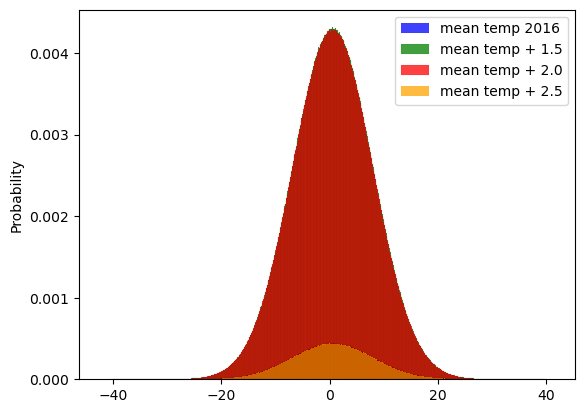

In [37]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(model_0_transform), stat='probability', bins=10000, ax=ax, color="blue", label = "mean temp")
sns.histplot(data=np.array(model_1_5_transform), stat='probability', bins=1000, ax=ax, color="green", label = "mean temp + 1.5")
sns.histplot(data=np.array(model_2_0_transform), stat='probability', bins=1000, ax=ax, color="red", label = "mean temp + 2.0")
sns.histplot(data=np.array(model_2_5_transform), stat='probability', bins=10000, ax=ax, color="orange", label = "mean temp + 2.5")
ax.legend()
high_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
low_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with low temp: ", np.sum(low_height))
print("Probability that tfp will increase with high temp: ", np.sum(high_height))

# Fix temp and infer drought

In [10]:
observed_model = observe(model, {
    "precip_posterior":[val for index, val in enumerate(normalized_precip) if not np.isnan(list(integrated_data["Unweighted_Temp"])[index])],
    "tfp_posterior":[val for index, val in enumerate(normalized_tfp) if not np.isnan(list(integrated_data["Unweighted_Temp"])[index])]
})

global_trace = pd.read_pickle(f"../models/temp_precip_drought_tfp_global.pkl")["trace"]

mean_temp = temp_scaler.transform(np.array([val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_1_5 = temp_scaler.transform(np.array([1.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_0 = temp_scaler.transform(np.array([2.0 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_5 = temp_scaler.transform(np.array([2.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()

model_0 = do(observed_model, {"temp_posterior": mean_temp})
model_1_5 = do(observed_model, {"temp_posterior": mean_temp_1_5})
model_2_0 = do(observed_model, {"temp_posterior": mean_temp_2_0})
model_2_5 = do(observed_model, {"temp_posterior": mean_temp_2_5})

model_0_drought_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_0,
    var_names=["drought_posterior"]
)
model_1_5_drought_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_1_5,
    var_names=["drought_posterior"]
)
model_2_0_drought_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_0,
    var_names=["drought_posterior"]
)
model_2_5_drought_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_5,
    var_names=["drought_posterior"]
)

Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


In [14]:
model_0_transform = np.array(model_0_drought_samples.posterior_predictive.drought_posterior.values).flatten()
model_1_5_transform = np.array(model_1_5_drought_samples.posterior_predictive.drought_posterior.values).flatten()
model_2_0_transform = np.array(model_2_0_drought_samples.posterior_predictive.drought_posterior.values).flatten()
model_2_5_transform = np.array(model_2_5_drought_samples.posterior_predictive.drought_posterior.values).flatten()

ATE_est_1_5 = np.mean(model_0_transform - model_1_5_transform)
ATE_est_2_0 = np.mean(model_0_transform - model_2_0_transform)
ATE_est_2_5 = np.mean(model_0_transform - model_2_5_transform)

print("ATE 1.5:", ATE_est_1_5)
print("ATE 2.0:", ATE_est_2_0)
print("ATE 2.5:", ATE_est_2_5)

0.06766988304093567
0.07251251461988305
0.07406444444444445
0.07581649122807017


# Joint effect of drought and temp on TFP

In [89]:
observed_model = observe(model, {
    "precip_posterior":[val for index, val in enumerate(normalized_precip) if not np.isnan(list(integrated_data["Unweighted_Temp"])[index])],
})

global_trace = pd.read_pickle(f"../models/temp_precip_drought_tfp_global.pkl")["trace"]

mean_temp = temp_scaler.transform(np.array([val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_1_5 = temp_scaler.transform(np.array([1.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_0 = temp_scaler.transform(np.array([2.0 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()
mean_temp_2_5 = temp_scaler.transform(np.array([2.5 + val for val in integrated_data["Unweighted_Temp"] if not np.isnan(val)]).reshape(-1,1)).flatten()

model_0 = do(observed_model, {"temp_posterior": mean_temp, "drought_posterior": [1 for i in range(len(mean_temp))]})
model_1_5 = do(observed_model, {"temp_posterior": mean_temp_1_5, "drought_posterior": [1 for i in range(len(mean_temp))]})
model_2_0 = do(observed_model, {"temp_posterior": mean_temp_2_0, "drought_posterior": [1 for i in range(len(mean_temp))]})
model_2_5 = do(observed_model, {"temp_posterior": mean_temp_2_5, "drought_posterior": [1 for i in range(len(mean_temp))]})

model_0_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_0,
    var_names=["tfp_posterior"]
)
model_1_5_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_1_5,
    var_names=["tfp_posterior"]
)
model_2_0_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_0,
    var_names=["tfp_posterior"]
)
model_2_5_tfp_samples = pm.sample_posterior_predictive(
    global_trace,
    model=model_2_5,
    var_names=["tfp_posterior"]
)

Sampling: [precip_posterior, tfp_posterior]


Sampling: [precip_posterior, tfp_posterior]


Sampling: [precip_posterior, tfp_posterior]


Sampling: [precip_posterior, tfp_posterior]


In [90]:
model_0_transform = tfp_scaler.inverse_transform(
    np.array(model_0_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_1_5_transform = tfp_scaler.inverse_transform(
    np.array(model_1_5_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_2_0_transform = tfp_scaler.inverse_transform(
    np.array(model_2_0_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()
model_2_5_transform = tfp_scaler.inverse_transform(
    np.array(model_2_5_tfp_samples.posterior_predictive.tfp_posterior.values).flatten().reshape(-1,1)
).flatten()

ATE_est_1_5 = np.mean(model_0_transform - model_1_5_transform)
ATE_est_2_0 = np.mean(model_0_transform - model_2_0_transform)
ATE_est_2_5 = np.mean(model_0_transform - model_2_5_transform)

print("ATE 1.5:", ATE_est_1_5)
print("ATE 2.0:", ATE_est_2_0)
print("ATE 2.5:", ATE_est_2_5)

ATE 1.5: 0.040983774087205646
ATE 2.0: 0.05958438168911811
ATE 2.5: 0.07973321735446051


# Parameter recovery to check model validity

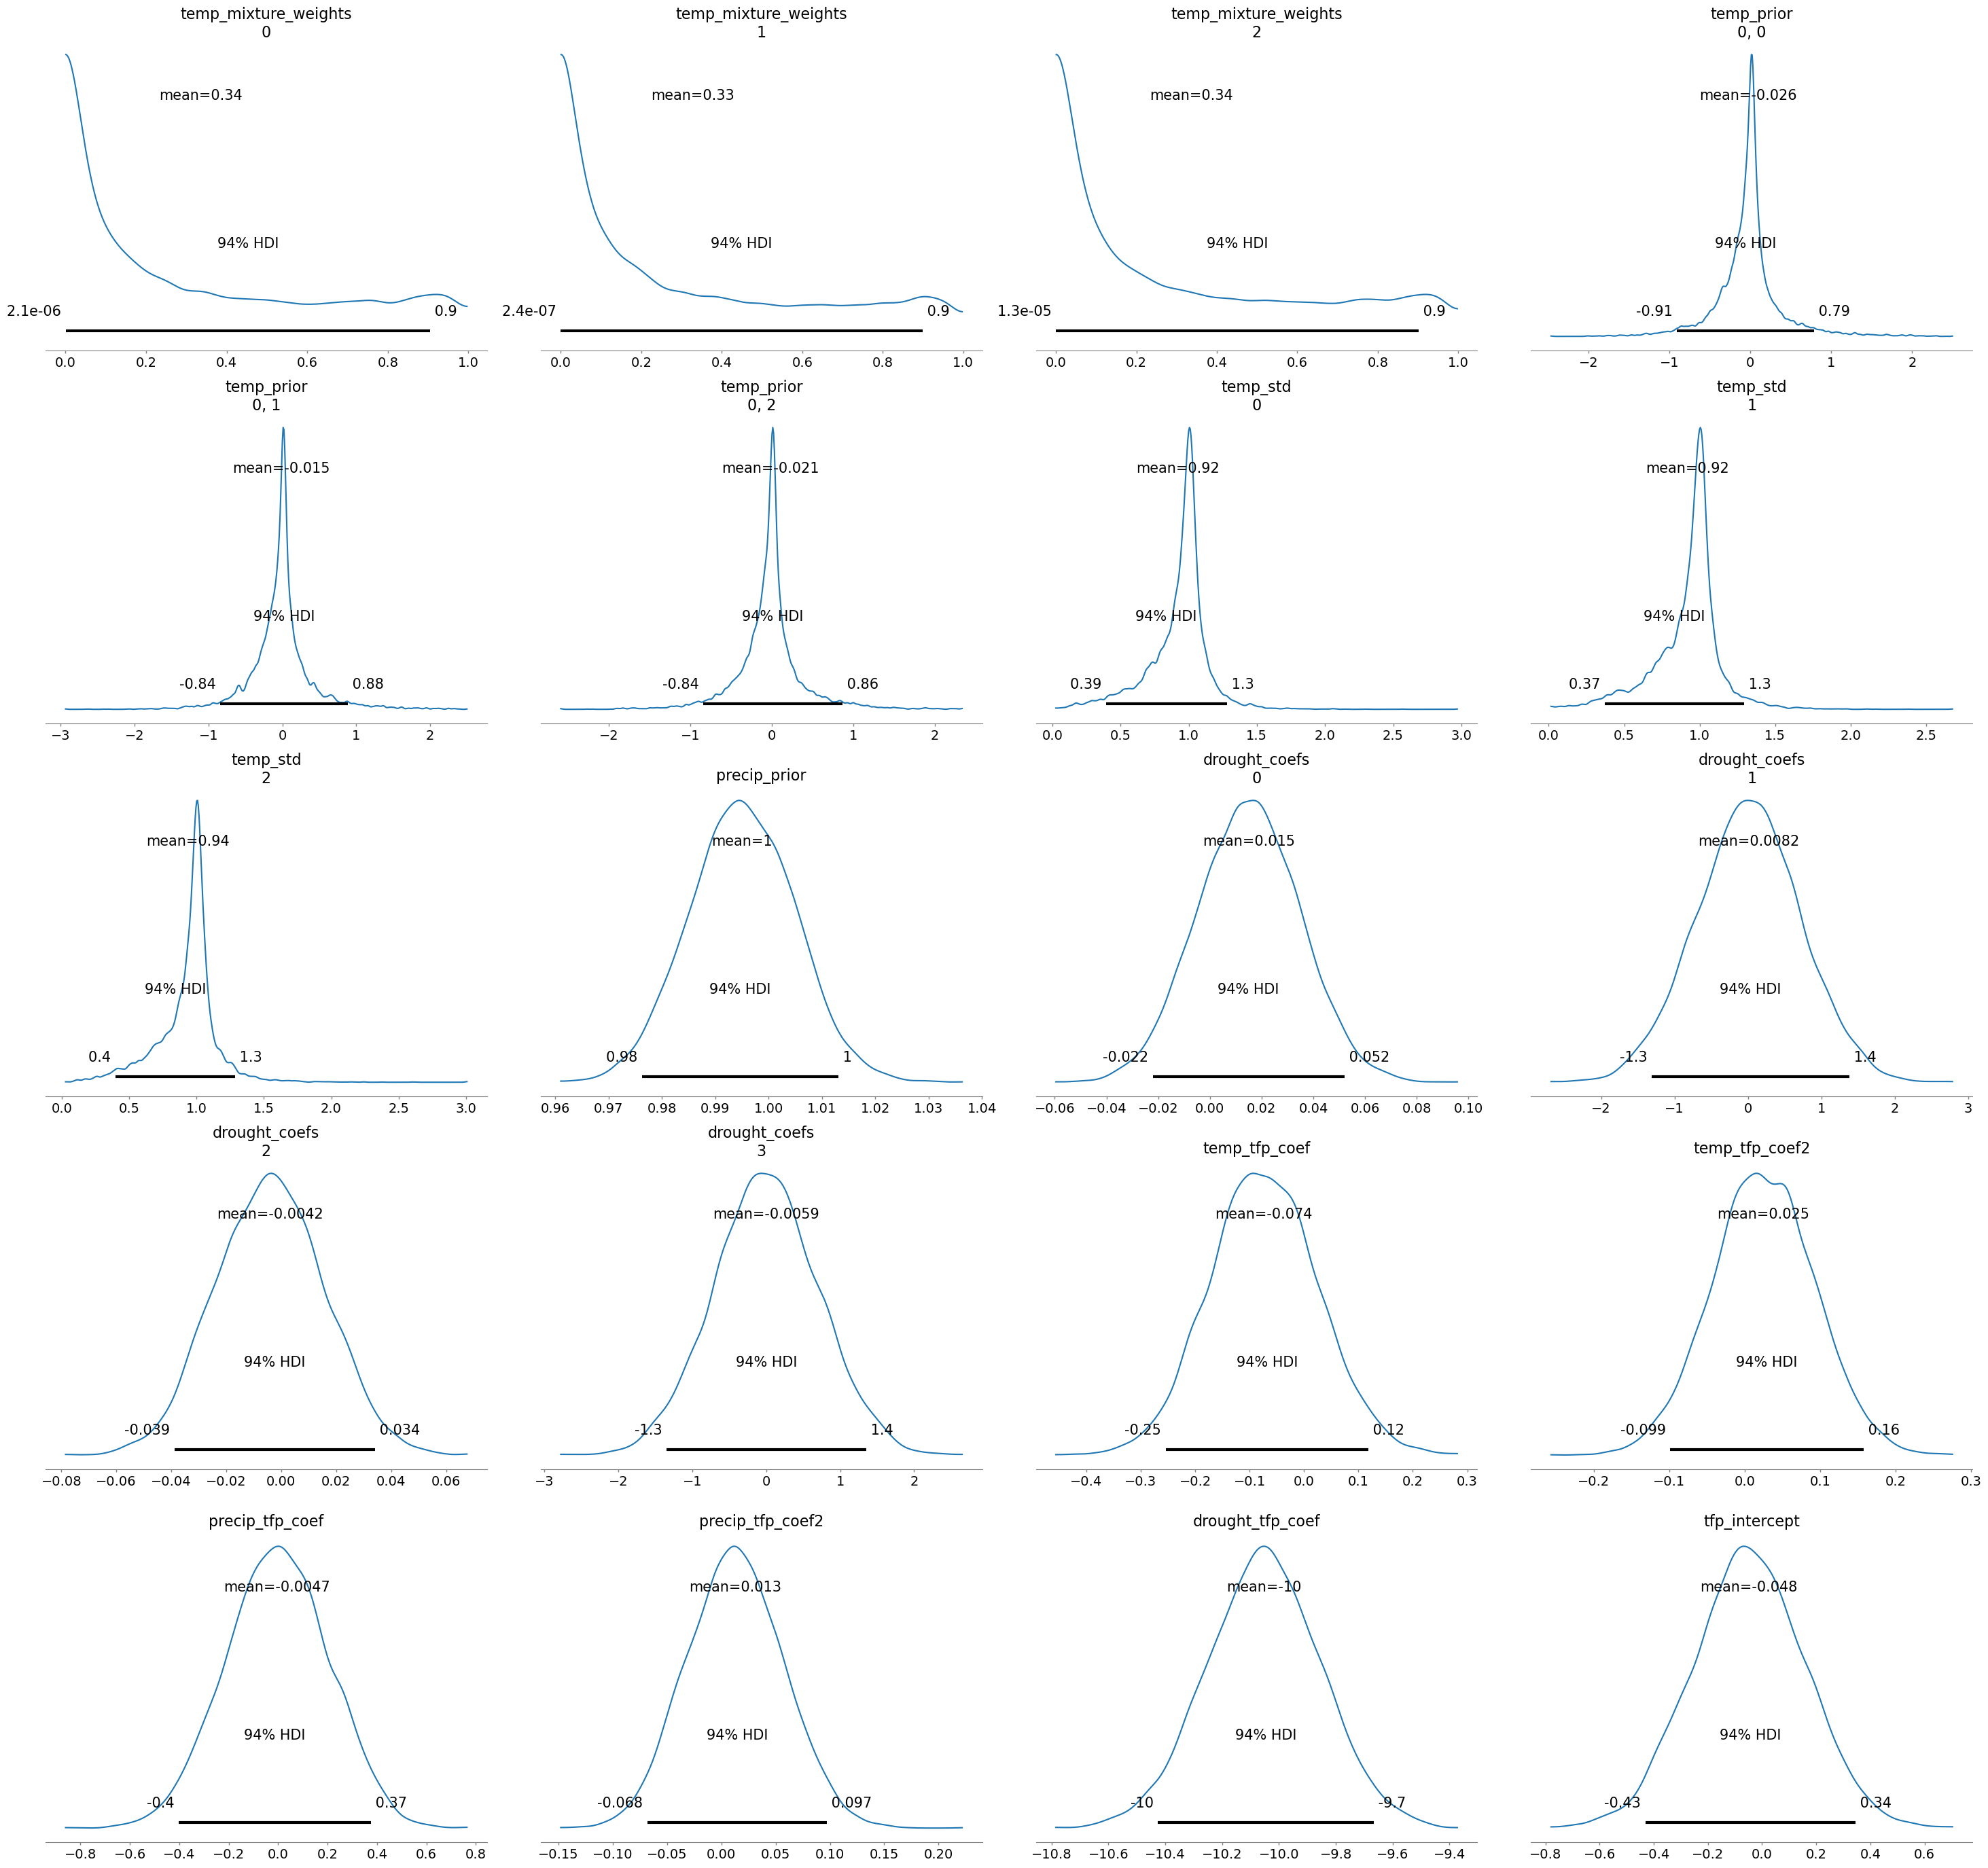

In [88]:
keys = list(set_values.keys())
az.plot_posterior(
    idata,
    var_names=keys,
)
plt.tight_layout();

# Regional Effect of Drought on TFP

## How much does drought effect tfp in each region? (Average Treatment Effect)

In [2]:
countries_by_region = {}
data_by_country = {}
data_by_region = {}
for country in set(integrated_data["Country"]):
    region = cc.convert(country, to="UNregion")
    if region not in countries_by_region:
        countries_by_region[region] = []
    countries_by_region[region].append(country)
for region, countries in countries_by_region.items():
    regional_data = integrated_data.loc[(integrated_data["Country"].isin(countries))]
    data_by_region[region] = regional_data
    for country in countries:
        data_by_country[country] = integrated_data.loc[(integrated_data["Country"]==country)]

In [52]:
results = {}

for region, data in data_by_region.items():
    print(region)
    results[region] = {"drought":[],"no_drought":[],"ATE":0}
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std,
            observed=normalized_temp
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior)
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)
    
    no_drought_model = do(model, {"drought_posterior": np.zeros(len(normalized_temp), dtype="int32")})
    drought_model = do(model, {"drought_posterior": np.ones(len(normalized_temp), dtype="int32")})

    # load regional model from pkl
    regional_trace = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")["trace"]
    
    no_drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=no_drought_model,
        var_names=["tfp_posterior"]
    )
    drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=drought_model,
        var_names=["tfp_posterior"]
    )
    
    ATE_est = (drought_tfp_samples.posterior_predictive - no_drought_tfp_samples.posterior_predictive).tfp_posterior.mean().values
    results[region]["ATE"] = ATE_est
    results[region]["drought"] = drought_tfp_samples.posterior_predictive.tfp_posterior.data.flatten()
    results[region]["no_drought"] = no_drought_tfp_samples.posterior_predictive.tfp_posterior.data.flatten()

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281581C40>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E3B44A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Western Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Central America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E07D000>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E0275A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


Southern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x284840AC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x284843760>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


Southern Europe


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


South America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x169C32420>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281DF1700>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281DE9B60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281DFC2E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Central Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Caribbean


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Western Europe


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


South-eastern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Northern Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Eastern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Australia and New Zealand


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Southern Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Melanesia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Northern America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


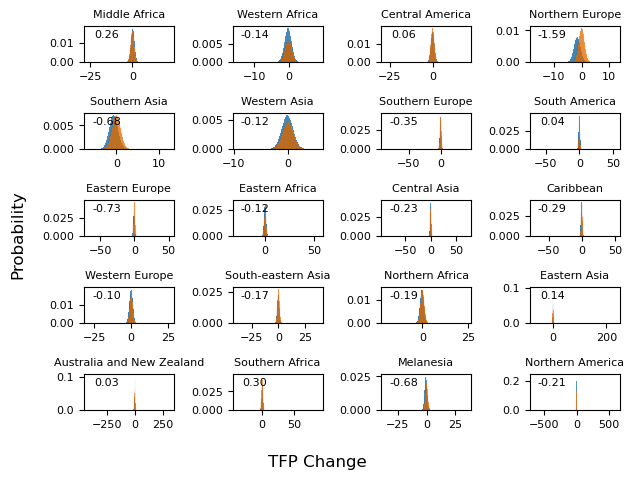

In [106]:
fig, axes = plt.subplots(5, 4)
axes = axes.flatten()
plt.subplots_adjust(hspace=1, wspace=0.5)
for index, region in enumerate(results):
    sns.histplot(data=np.array(results[region]["drought"]), stat='probability', bins=1000, ax=axes[index], label = "Drought")
    sns.histplot(data=np.array(results[region]["no_drought"]), stat='probability', bins=1000, ax=axes[index], label = "No Drought")
    axes[index].set_title(region)
    axes[index].title.set_fontsize(8)
    axes[index].tick_params(axis='both', which='both', labelsize=8)
    axes[index].set_ylabel('', fontsize=.01, labelpad=.01)
    ate = str(results[region]["ATE"])
    if ate[0] == "-":
        ate = ate[:5]
    else:
        ate = ate[:4]
    axes[index].text(0.25, 0.75, ate, transform=axes[index].transAxes, fontsize=8, verticalalignment='center', horizontalalignment='center')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines[:2], labels[:2], loc="outside upper center")
fig.supxlabel('TFP Change')
fig.supylabel('Probability')
fig.tight_layout()
fig.savefig("../figures/drought_tfp_regional_subplots.png")

# Regional effect of temperature on tfp

In [108]:
results = {}

for region, data in data_by_region.items():
    print(region)
    results[region] = {"samples_norm_temp":[],"samples_1_5":[],"samples_2_0":[],"samples_2_5":[],"ATE_1_5":0, "ATE_2_0":0, "ATE_2_5":0}
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["Drought"])
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

    # load regional model from pkl
    regional_model = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")
    regional_trace = regional_model["trace"]
    # TODO: Fix this, it is not taking the mean 2016 temp of all countries in the region
    mean_temp = [val for val in np.array(data["Unweighted_Temp"]) if not np.isnan(val)][-1]
    mean_temp_data = np.zeros(len(normalized_temp)) + mean_temp
    
    mean_temp_scaled = temp_scaler.transform(mean_temp_data.reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase_1_5 = temp_scaler.transform(np.array([mean_temp + 1.5 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase_2_0 = temp_scaler.transform(np.array([mean_temp + 2.0 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase_2_5 = temp_scaler.transform(np.array([mean_temp + 2.5 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()

    temp_model_1_5 = do(model, {"temp_posterior": mean_temp_scaled_temp_increase_1_5})
    temp_model_2_0 = do(model, {"temp_posterior": mean_temp_scaled_temp_increase_2_0})
    temp_model_2_5 = do(model, {"temp_posterior": mean_temp_scaled_temp_increase_2_5})
    low_temp_model = do(model, {"temp_posterior": mean_temp_scaled})
    
    temp_tfp_samples_1_5 = pm.sample_posterior_predictive(
        regional_trace,
        model=temp_model_1_5,
        var_names=["tfp_posterior"]
    )
    temp_tfp_samples_2_0 = pm.sample_posterior_predictive(
        regional_trace,
        model=temp_model_2_0,
        var_names=["tfp_posterior"]
    )
    temp_tfp_samples_2_5 = pm.sample_posterior_predictive(
        regional_trace,
        model=temp_model_2_5,
        var_names=["tfp_posterior"]
    )
    low_temp_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=low_temp_model,
        var_names=["tfp_posterior"]
    )
    
    ATE_1_5 = temp_tfp_samples_1_5.posterior_predictive - low_temp_tfp_samples.posterior_predictive
    ATE_2_0 = temp_tfp_samples_2_0.posterior_predictive - low_temp_tfp_samples.posterior_predictive
    ATE_2_5 = temp_tfp_samples_2_5.posterior_predictive - low_temp_tfp_samples.posterior_predictive
    
    results[region]["ATE_1_5"] = ATE_1_5
    results[region]["ATE_2_0"] = ATE_2_0
    results[region]["ATE_2_5"] = ATE_2_5

    results[region]["samples_norm_temp"] = low_temp_tfp_samples.posterior_predictive.tfp_posterior.data.flatten()
    results[region]["samples_1_5"] = temp_tfp_samples_1_5.posterior_predictive.tfp_posterior.data.flatten()
    results[region]["samples_2_0"] = temp_tfp_samples_2_0.posterior_predictive.tfp_posterior.data.flatten()
    results[region]["samples_2_5"] = temp_tfp_samples_2_5.posterior_predictive.tfp_posterior.data.flatten()

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A4398120>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A439B840>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2C481B060>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A4350740>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Western Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Central America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2EAF0BA00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2EAF092A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2FB324F20>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2FB324740>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Southern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2ABAEFE60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2CC5CDEE0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2CC5CC820>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2CC5CEEA0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Southern Europe


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


South America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30400DE00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30400D7E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30400CC80>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30400F920>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28C6DADC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28C6DA880>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x36C78C200>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x36C78DE00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Central Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Caribbean


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Western Europe


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


South-eastern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Northern Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Eastern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Australia and New Zealand


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Southern Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Melanesia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Northern America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


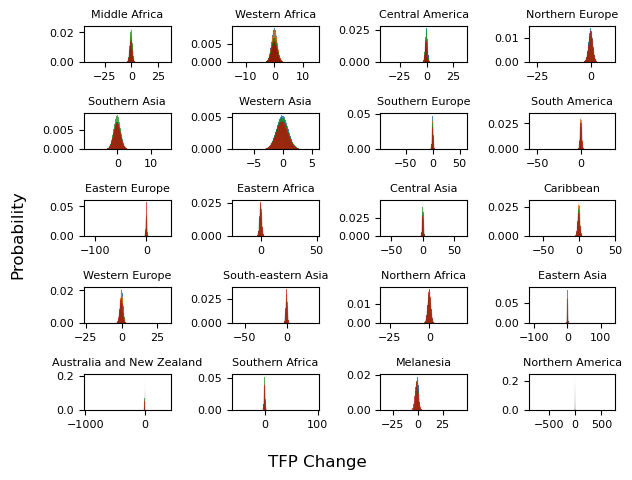

In [109]:
fig, axes = plt.subplots(5, 4)
axes = axes.flatten()
plt.subplots_adjust(hspace=1, wspace=0.5)
for index, region in enumerate(results):
    sns.histplot(data=np.array(results[region]["samples_norm_temp"]), stat='probability', bins=1000, ax=axes[index], label = "Normal Mean Temp")
    sns.histplot(data=np.array(results[region]["samples_1_5"]), stat='probability', bins=1000, ax=axes[index], label = "+ 1.5C Mean Temp")
    sns.histplot(data=np.array(results[region]["samples_2_0"]), stat='probability', bins=1000, ax=axes[index], label = "+ 2.0C Mean Temp")
    sns.histplot(data=np.array(results[region]["samples_2_5"]), stat='probability', bins=1000, ax=axes[index], label = "+ 2.5C Mean Temp")
    axes[index].set_title(region)
    axes[index].title.set_fontsize(8)
    axes[index].tick_params(axis='both', which='both', labelsize=8)
    axes[index].set_ylabel('', fontsize=.01, labelpad=.01)
    # ate = str(results[region]["ATE"])
    # if ate[0] == "-":
    #     ate = ate[:5]
    # else:
    #     ate = ate[:4]
    # axes[index].text(0.25, 0.75, ate, transform=axes[index].transAxes, fontsize=8, verticalalignment='center', horizontalalignment='center')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines[:2], labels[:2], loc="outside upper center")
fig.supxlabel('TFP Change')
fig.supylabel('Probability')
fig.tight_layout()
fig.savefig("../figures/temp_tfp_regional_subplots.png")

# Regional effect of temperature on drought

Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17CD219A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17CD21FC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Eastern Europe = -0.00


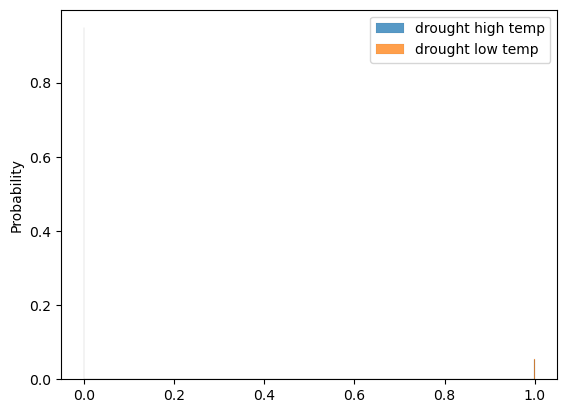

Melanesia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Melanesia = 0.02


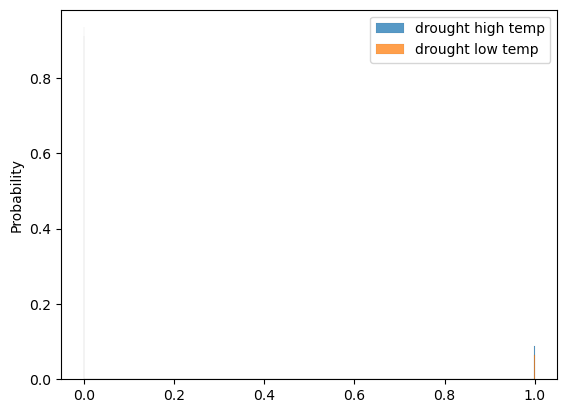

South-eastern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for South-eastern Asia = 0.01


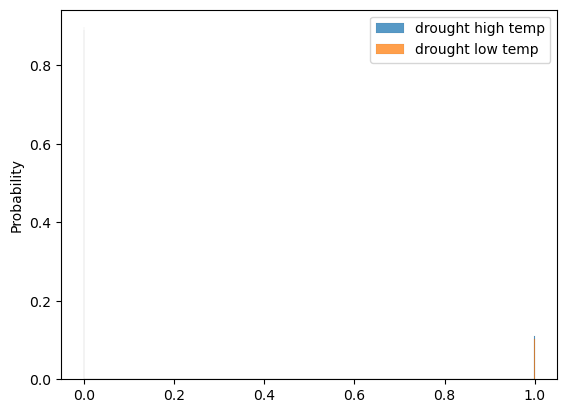

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1197790E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BDC59A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Middle Africa = 0.01


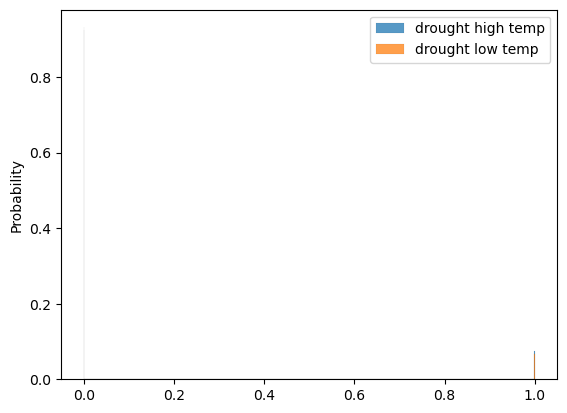

South America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for South America = 0.02


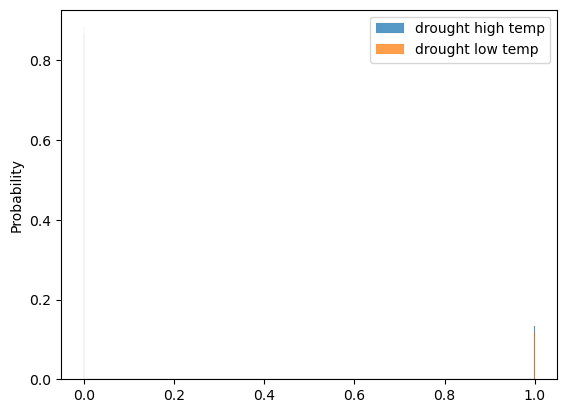

Central America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Central America = 0.01


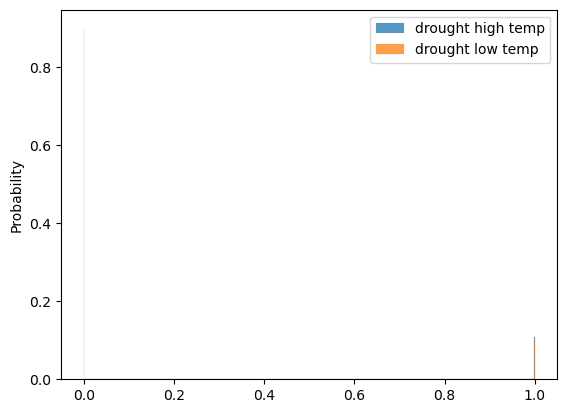

Northern Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Northern Africa = -0.01


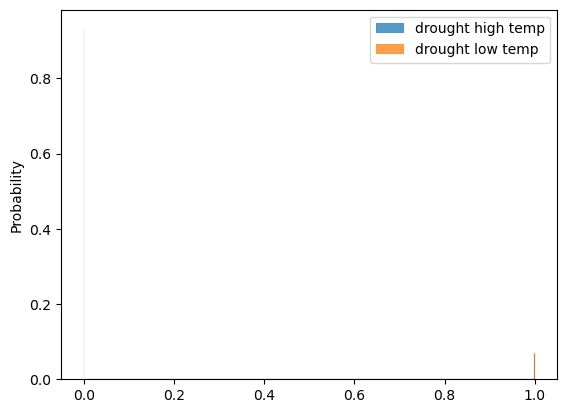

Southern Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Africa = 0.00


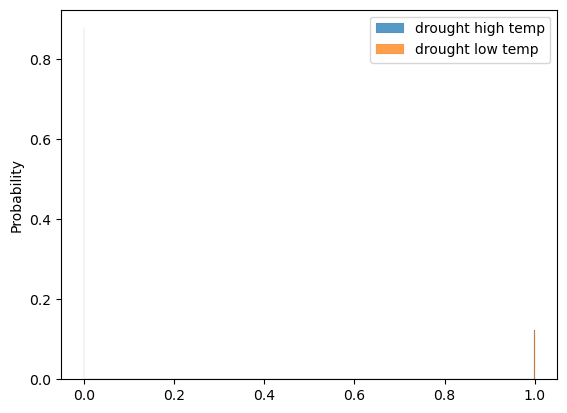

Western Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Western Africa = 0.07


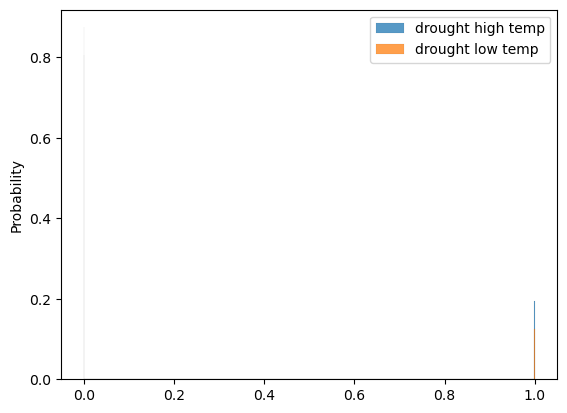

Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BEA98C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BEA84A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Eastern Africa = 0.02


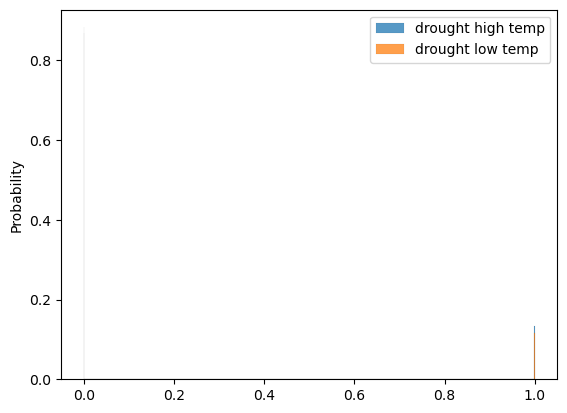

Caribbean


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Caribbean = 0.06


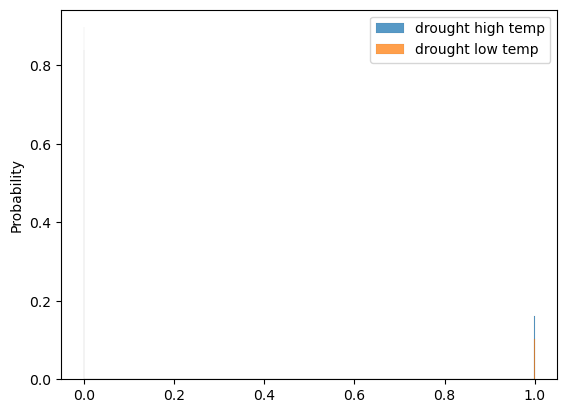

Central Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Central Asia = -0.00


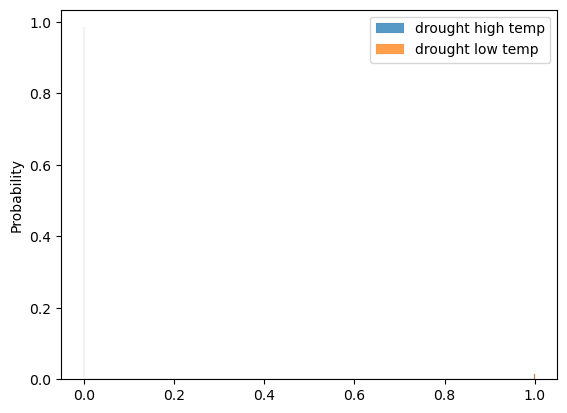

Southern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Asia = 0.01


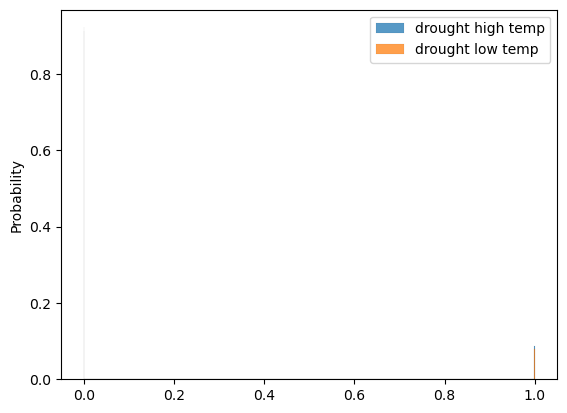

Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E2C2420>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E6E7CA0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Western Asia = -0.00


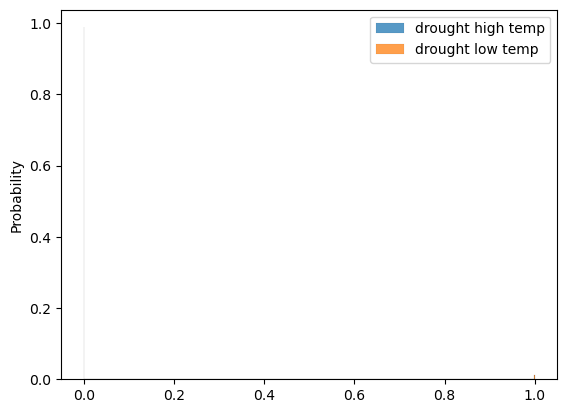

Eastern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Eastern Asia = -0.01


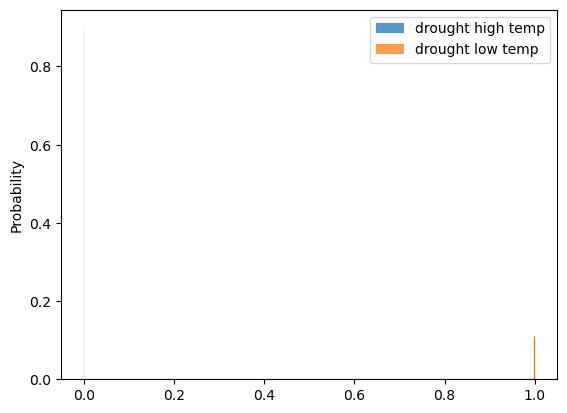

Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1795C5E00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11980BA00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Northern Europe = 0.00


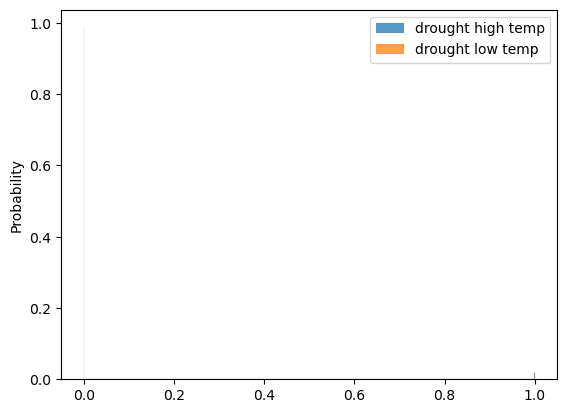

Southern Europe


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Europe = 0.03


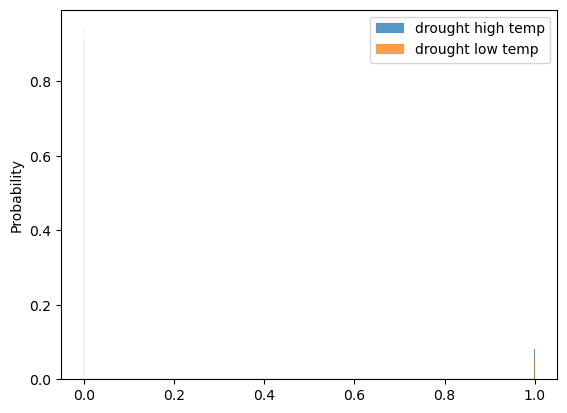

Northern America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Northern America = 0.01


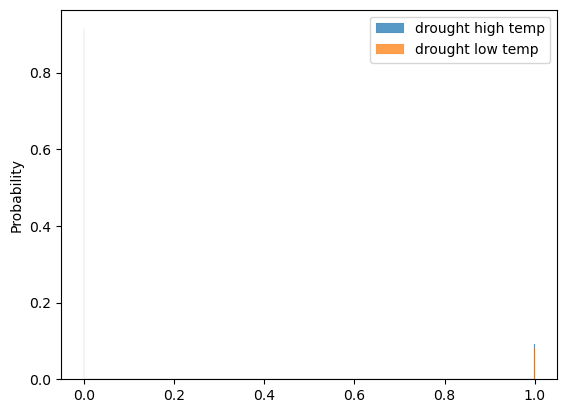

Western Europe


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Western Europe = 0.04


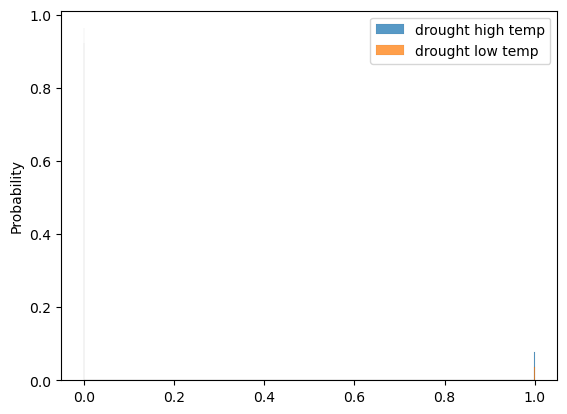

Australia and New Zealand


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Australia and New Zealand = 0.01


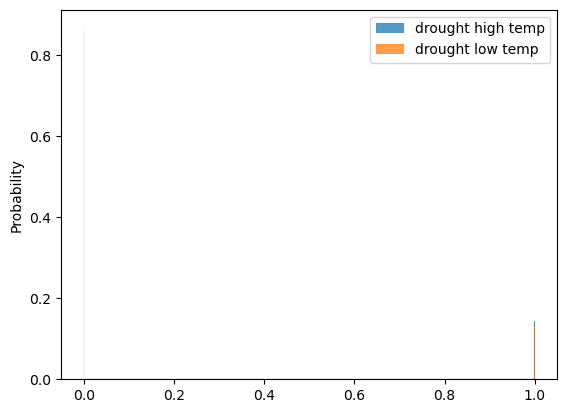

In [44]:
for region, data in data_by_region.items():
    print(region)
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["Drought"])
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

    # load regional model from pkl
    regional_model = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")
    regional_trace = regional_model["trace"]
    # TODO: Fix this, it is not taking the mean 2016 temp of all countries in the region
    mean_temp = [val for val in np.array(data["Unweighted_Temp"]) if not np.isnan(val)][-1]
    mean_temp_data = np.zeros(len(normalized_temp)) + mean_temp
    mean_temp_scaled = temp_scaler.transform(mean_temp_data.reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase = temp_scaler.transform(np.array([mean_temp + 1.5 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()

    high_temp_model = do(model, {"temp_posterior": mean_temp_scaled_temp_increase})
    low_temp_model = do(model, {"temp_posterior": mean_temp_scaled})
    
    high_temp_drought_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=high_temp_model,
        var_names=["drought_posterior"]
    )
    low_temp_drought_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=low_temp_model,
        var_names=["drought_posterior"]
    )
    
    ATE_est = high_temp_drought_samples.posterior_predictive - low_temp_drought_samples.posterior_predictive
    print(f"Estimated ATE for {region} = {ATE_est.drought_posterior.mean().values:.2f}")
    
    fig, ax = plt.subplots()
    sns.histplot(data=np.array(high_temp_drought_samples.posterior_predictive.drought_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="drought high temp")
    sns.histplot(data=np.array(low_temp_drought_samples.posterior_predictive.drought_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="drought low temp")
    ax.legend()
    plt.show()